# Laboratorio: Analizando el IMAE de Costa Rica

<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
</center>
<i>Creado:     2022-Ago-21 
    <br>
 Actualizado: 2025-Ago-09</i>

En este cuaderno de Jupyter se ilustran varios de los conceptos del **Tema 1: Introducción al análisis de series de tiempo**.

## 1. Importar los paquetes necesarios para este ejemplo

In [1]:
from bccr import SW
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats.distributions import chi2  # distribución Chi-cuadrado

En este bloque controlamos las propiedades de las figuras

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-talk')
plt.rc('figure', figsize=[12, 5])
plt.rc('savefig', bbox='tight', transparent=True)

figpath = "../figures/"  # Ajustar esta carpeta, donde serán guardadas las figuras
SAVEFIGS = True  # Cambiar a False si no se quieren guardar las figuras

## 2. Descargar los datos

Usamos el paquete `bccr` para buscar datos del IMAE.

In [3]:
SW.buscar(todos='IMAE', Unidad='Nivel')


,DESCRIPCION,Unidad,Medida,periodo
codigo,,,,
3669,Sector Real/Indice Mensual Actividad Económica (IMAE) [3669]',Nivel,NaN,Mensual
22717,"Sector Real/IMAE con IEAT, Desestacionalizada [22717]'",Nivel,NaN,Mensual
22966,Sector Real/IMAE sin Zona Franca [22966]',Nivel,NaN,Mensual
35445,Sector Real/Indice Mensual Actividad Económica (IMAE) [35445]',Nivel,NaN,Mensual
87701,Sector Real/Indice Mensual Actividad Económica (IMAE) [87701]',Nivel,NaN,Mensual


Descargamos la serie 87764. Además, eliminamos el nombre del índice de la tabla de pandas para que no la muestre en el eje horizontal de los gráficos (puesto que es obvio que se tratan de meses).

In [4]:
imae = SW(IMAE=87764)
imae.index.name = ''

## 3. Graficar la serie de tiempo, en distintas versiones

Definimos la función `marcar_episodio` para facilitar hacer anotaciones en nuestros gráficos. Además, definimos las listas `años_ticks` y `años_ticklabels` para controlar la ubicación y el texto de las marcas en el eje horizontal.

In [5]:
def marcar_episodio(ax, nombre, serie, fecha, dx, dy, ha):
    fecha = pd.Period(fecha,freq='M')
    y = serie.loc[fecha].iloc[0]

    ax.annotate(nombre, 
             (fecha, y), 
             (fecha+dx, y + dy), 
             fontsize=16, color="#7D2A21",
             arrowprops=dict(width=2, color="#7D2A21",shrink=0.05),
             ha=ha             
             )

años_ticks = [pd.Period(f'{año}', freq='M') for año in np.arange(1995,2025,5)]     
años_ticklabels = [año.year for año in años_ticks] 

Graficamos el nivel de la serie del IMAE tendencia-ciclo. Anotamos en la figura tres episodios: la quiebra del Banco Anglo, la Gran Recesión, y la pandemia Covid-19; en estos tres episodios es notorio una contracción en la economía, caracterizada por un quiebre en la tendencia de la serie.

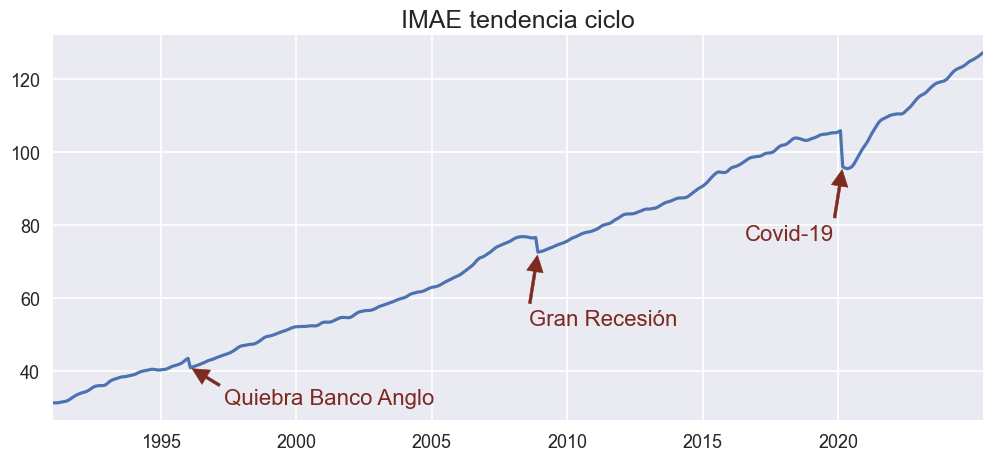

In [6]:
fig, ax = plt.subplots()
imae.plot(ax=ax, legend=None)
ax.set_title("IMAE tendencia ciclo", fontsize=18)
ax.set(xticks=años_ticks, 
       xticklabels=años_ticklabels)
marcar_episodio(ax, 'Quiebra Banco Anglo', imae, '1996-02',15, -10, 'left')
marcar_episodio(ax, 'Gran Recesión', imae,'2008-12',-4, -20, 'left')
marcar_episodio(ax, 'Covid-19', imae,'2020-3',-4, -20, 'right')

if SAVEFIGS:
    fig.savefig(figpath + "ej-imae-nivel.png")

Calculamos la tasa de crecimiento mensual del IMAE, como la primer diferencia del logaritmo de la serie en nivel. En este gráfico es aún más notorio los tres episodios de crisis mencionados anteriormente.

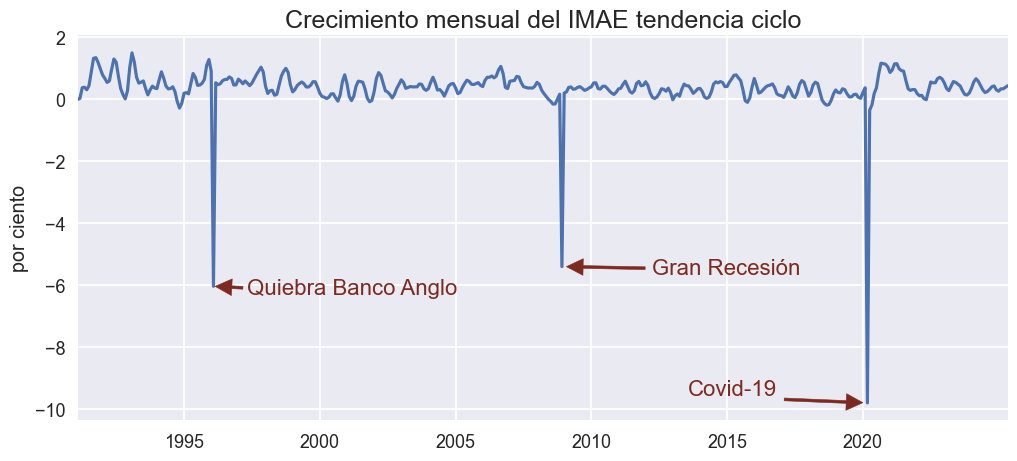

In [7]:
limae = np.log(imae)

Dlimae = 100* limae.diff().dropna()

fig, ax = plt.subplots()
Dlimae.plot(ax=ax, legend=None)
ax.set_title("Crecimiento mensual del IMAE tendencia ciclo", fontsize=18)
ax.set(ylabel='por ciento',
       xticks=años_ticks, 
       xticklabels=años_ticklabels)
marcar_episodio(ax, 'Quiebra Banco Anglo', Dlimae, '1996-02',15, -0.25, 'left')
marcar_episodio(ax, 'Gran Recesión', Dlimae,'2008-12',+40, -0.25, 'left')
marcar_episodio(ax, 'Covid-19', Dlimae,'2020-3',-40, +0.25, 'right')

if SAVEFIGS:
    fig.savefig(figpath + "ej-imae-crecimiento.png")

Ahora definimos la serie `Dlimae_ajustado`, donde eliminamos los episodios de crisis (nótese las discontinuidades en el gráfico). La idea es ver cómo cambian las propiedades de la serie de tiempo cuando se excluyen o no los periodos de crisis.

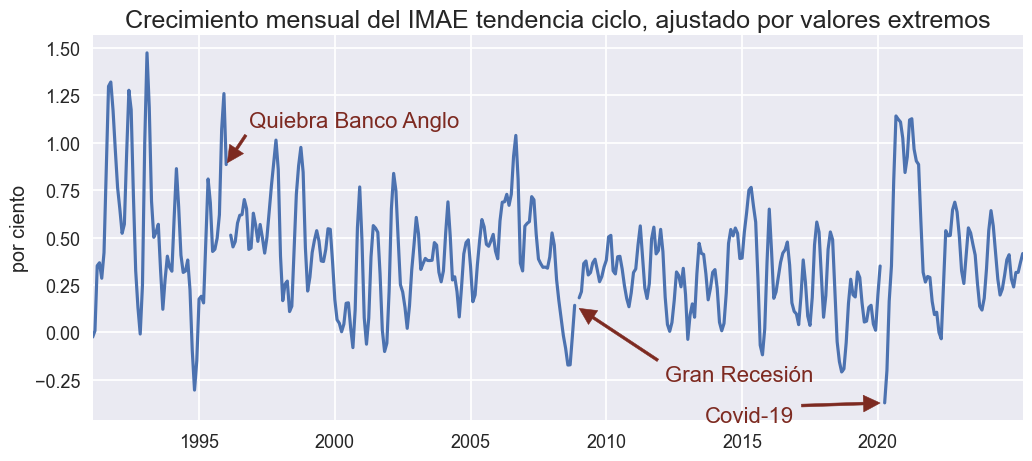

In [8]:
Dlimae_ajustado = Dlimae[Dlimae > -4]

fig, ax = plt.subplots()
Dlimae_ajustado.plot(ax=ax, legend=None)
ax.set_title("Crecimiento mensual del IMAE tendencia ciclo, ajustado por valores extremos", fontsize=18)
ax.set(ylabel='por ciento',
       xticks=años_ticks, 
       xticklabels=años_ticklabels)
marcar_episodio(ax, 'Quiebra Banco Anglo', Dlimae_ajustado, '1996-01',10, 0.2, 'left')
marcar_episodio(ax, 'Gran Recesión', Dlimae_ajustado,'2008-11',+40, -0.4, 'left')
marcar_episodio(ax, 'Covid-19', Dlimae_ajustado,'2020-4',-40, -0.1, 'right')

if SAVEFIGS:
   fig.savefig(figpath + "ej-imae-ajustado.png")

Finalmente, graficamos la tasa de crecimiento interanual del IMAE. En esta nueva figura la recuperación de la tasa de crecimiento luego de un período de crisis pareces ser más lenta. No obstante, esta persistencia es simplemente resultado de que al calcular tasas interanuales, las observaciones mensuales consecutivas tienen muchos períodos en común.

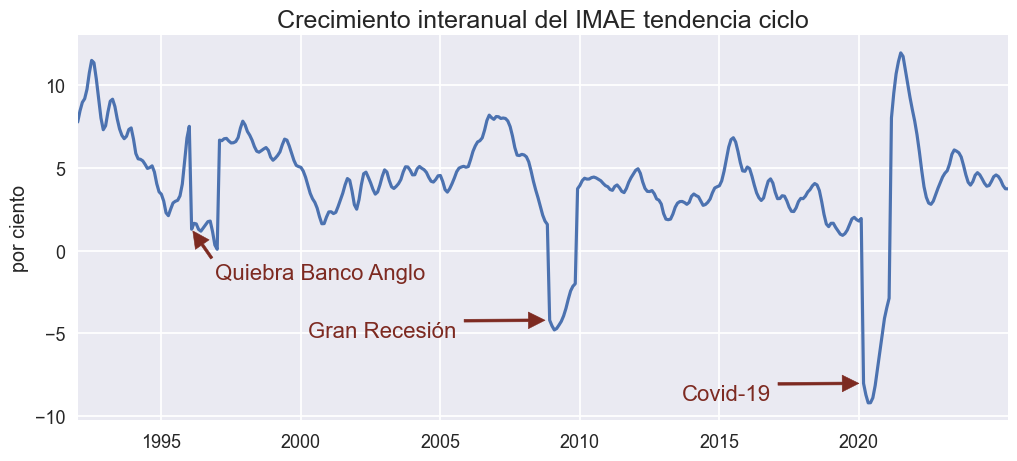

In [9]:
Dlimae12 = 100* limae.diff(12).dropna()

fig, ax = plt.subplots()
Dlimae12.plot(ax=ax, legend=None)
ax.set_title("Crecimiento interanual del IMAE tendencia ciclo", fontsize=18)
ax.set(ylabel='por ciento',
       xticks=años_ticks, 
       xticklabels=años_ticklabels)
marcar_episodio(ax, 'Quiebra Banco Anglo', Dlimae12, '1996-02',10, -3, 'left')
marcar_episodio(ax, 'Gran Recesión', Dlimae12,'2008-12',-40, -1, 'right')
marcar_episodio(ax, 'Covid-19', Dlimae12,'2020-3',-40, -1, 'right')

if SAVEFIGS:
    fig.savefig(figpath + "ej-imae-interanual.png")

## 4. Analizar el autocorrelograma y el autocorrelograma parcial

Primeros definimos unas opciones para los gráficos. Además, definimos `plot_acf` y  `plot_pacf` como las respectivas funciones de `statsmodels`, para que sea más fácil de digitar abajo (para no tener que escribir `sm.graphics.tsa.` a cada rato!).

In [10]:
OPCIONES = dict(lags=48, alpha=0.05, zero=False, missing='drop')
plot_acf = sm.graphics.tsa.plot_acf
plot_pacf = sm.graphics.tsa.plot_pacf

Presentamos cuatro autocorrelogramas:

- la serie en nivel (log), $\ln(y_t)$: vemos que las correlaciones disminuyen muy lentamente, lo cual es típico de una serie que tiene una tendencia marcada.
- la tasas de crecimiento interanual, $\ln(y_t) - \ln(y_{t-12})$: las correlaciones disminuyen más rápidamente, pero los primeros rezagos son significativos, esto es el resultado de la "persistencia" que artificialmente se le imprime a la serie cuando se calcula una tasa de crecimiento interanual.
- la tasas de crecimiento mensual, $\ln(y_t) - \ln(y_{t-1})$: aparentemente es prácticamente ruido blanco. 
- la tasas de crecimiento mensual ajustada, $\ln(y_t) - \ln(y_{t-1})\quad ajustada$: vemos que al eliminar los episodios extremos, el crecimiento mensual sí está correlacionado (al menos los primeros rezagos sí son significativos). Esto sugiere que los rezagos del crecimiento del IMAE sí tienen poder predictivo.

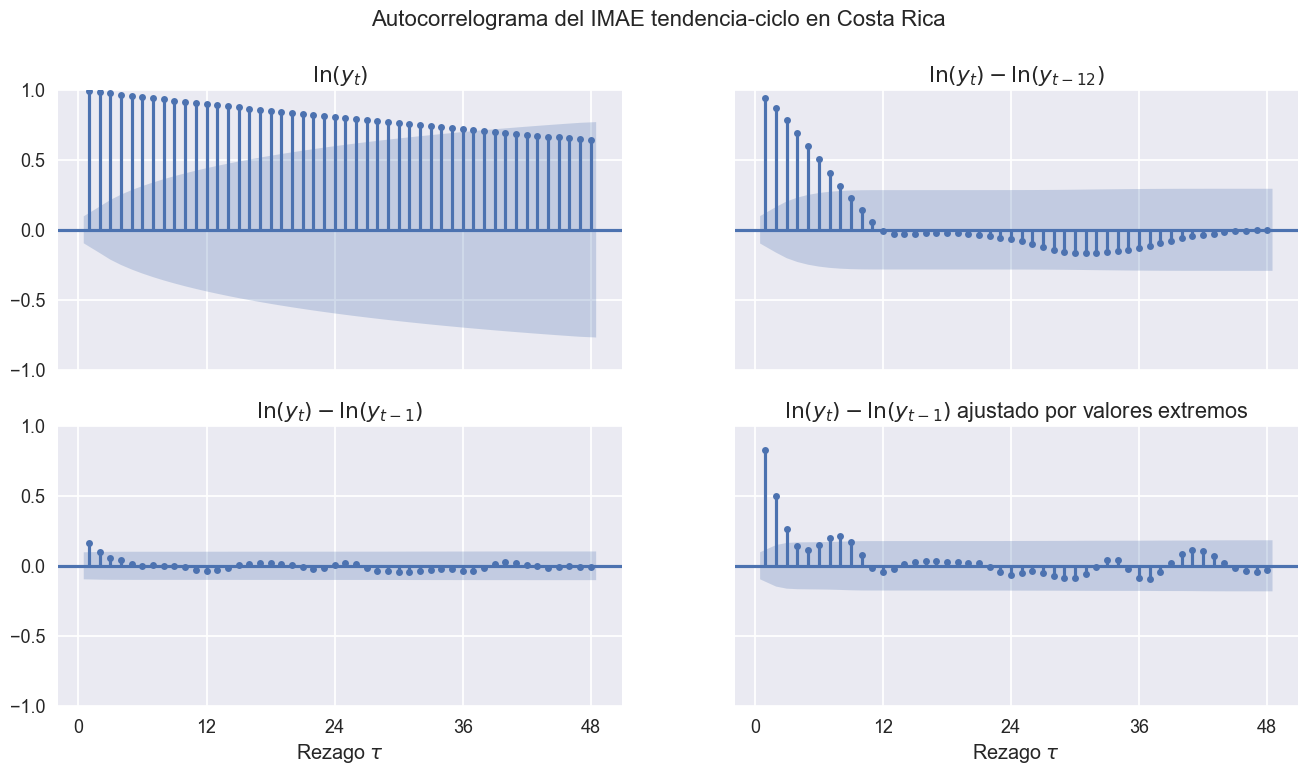

In [11]:
fig, axs = plt.subplots(2,2, figsize=[16,8], sharex=True, sharey='row')


plot_acf(limae, ax=axs[0,0], title=r'$\ln(y_t)$', **OPCIONES);
plot_acf(Dlimae, ax=axs[1,0], title=r'$\ln(y_t) - \ln(y_{t-1})$', **OPCIONES);
plot_acf(Dlimae_ajustado, ax=axs[1,1], title=r'$\ln(y_t) - \ln(y_{t-1})$ ajustado por valores extremos', **OPCIONES);
plot_acf(Dlimae12, ax=axs[0,1], title=r'$\ln(y_t) - \ln(y_{t-12})$', **OPCIONES);

for ax in axs[-1]:
    ax.set(xlabel=r'Rezago $\tau$',
           xticks=np.arange(0,49,12));

fig.suptitle('Autocorrelograma del IMAE tendencia-ciclo en Costa Rica', size=16)

if SAVEFIGS:
    fig.savefig(figpath + "ej-imae-acf.png")

Ahora presentamos cuatro autocorrelogramas parciales:

- la serie en nivel (log), $\ln(y_t)$: vemos que solo la primera autocorrelación parcial es significativa (en sentido económico y estadístico), lo cual nos indica que la razón por las que las autocorrelaciones del gráfico anterior bajaban lentamente es por la influencia indirecta de los rezagos sobre la serie .
- la tasas de crecimiento interanual, $\ln(y_t) - \ln(y_{t-12})$: la primera correlación parcial es considerablemente alta. Vemos que este cálculo parece inducir un comportamiento estacional en la serie, que puede deberse en realidad a que los cálculos incluyen los períodos de crisis.
- la tasas de crecimiento mensual, $\ln(y_t) - \ln(y_{t-1})$: de nuevo, aparentemente es prácticamente ruido blanco. 
- la tasas de crecimiento mensual ajustada, $\ln(y_t) - \ln(y_{t-1})\quad ajustada$: vemos que al eliminar los episodios extremos, al menos los primeros 5 rezagos tienen poder explicativo sobre el crecimiento mensual del IMAE.

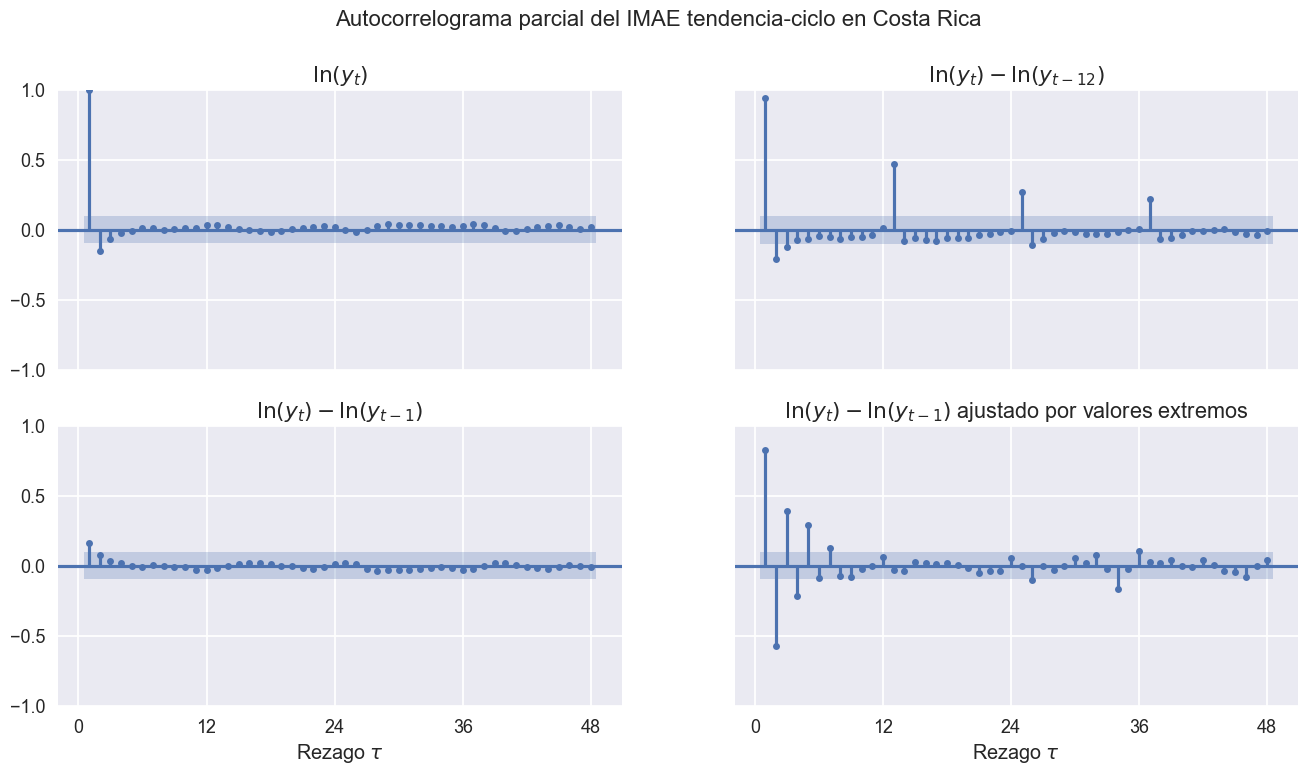

In [12]:
fig, axs = plt.subplots(2,2, figsize=[16,8], sharex=True, sharey='row')


OPCIONES2 = dict(lags=48, alpha=0.05, method='ols', zero=False)

plot_pacf(limae, ax=axs[0,0], title=r'$\ln(y_t)$', **OPCIONES2);
plot_pacf(Dlimae, ax=axs[1,0], title=r'$\ln(y_t) - \ln(y_{t-1})$', **OPCIONES2);
plot_pacf(Dlimae_ajustado.dropna(), ax=axs[1,1], title=r'$\ln(y_t) - \ln(y_{t-1})$ ajustado por valores extremos', **OPCIONES2);
plot_pacf(Dlimae12, ax=axs[0,1], title=r'$\ln(y_t) - \ln(y_{t-12})$', **OPCIONES2);

for ax in axs[-1]:
    ax.set(xlabel=r'Rezago $\tau$',
           xticks=np.arange(0,49,12))

fig.suptitle('Autocorrelograma parcial del IMAE tendencia-ciclo en Costa Rica', size=16)

if SAVEFIGS:
    fig.savefig(figpath + "ej-imae-pacf.png")   

## 5. Pruebas de ruido blanco

Definimos algunos parámetros necesarios para realizar las pruebas de hipótesis

In [13]:
growth = Dlimae_ajustado.dropna()
T = growth.size  # número de datos
M = 12   # máximo número de rezagos
rezagos = np.arange(1, M+1)
alpha = 0.05  # significancia de los test

### Box-Pierce y Ljung-Box
**Statsmodels** no da los resultados de las pruebas en un formato particulamente útil; por ello definimos la función `estadísticos` para tener ordenados nuestros resultados en una tabla de **pandas**. $\chi^2$

In [14]:
def estadisticos(serie, nlags=12, alpha=0.05):
    # serie = la serie de tiempo para la prueba
    # nlags = máximo número de rezagos que se calculará
    # alpha = nivel de significancia para la prueba 𝜒2

    rezagos = np.arange(1, nlags+1)
    T = serie.size  # número de observaciones

    # Definimos el dataframe, pero sin datos aún. Las columnas son los estadísticos y las filas los distintos rezagos
    df = pd.DataFrame(columns=['AC', 'PAC', 'Q*', 'Q', '𝜒2'], index=rezagos) 
    
    # en estas dos líneas el término  "[1:]" es para no incluir el rezago 0, que siempre es igual a 1.0
    df['AC'] = sm.tsa.acf(serie, fft=True, nlags=nlags)[1:] # autocorrelaciones
    df['PAC'] = sm.tsa.pacf(serie, nlags=nlags, method='ols')[1:] # autocorrelaciones parciales
    
    # Ver páginas 55 y 56 de los apuntes de clase. La idea con cumsum es para hacer la prueba con distintos valores de "m"
    df['Q*'] = T * (df['AC'] ** 2).cumsum() # test de Box-Pierce
    df['Q'] = T * (T+2) * ((df['AC'] ** 2)/(T-rezagos)).cumsum() # test de Ljung-Box
    df['𝜒2'] = np.array([chi2(m).ppf(1-alpha) for m in rezagos]) # valores críticos 𝜒2 con "m" grados de libertad

    df.index.name = 'Rezagos'
    return df

Al hacer la serie de crecimiento mensual ajustado por los períodos de crisis, los estadísticos Q siempre son mayores que los valores críticos: la serie no es ruido blanco.

In [15]:
estadisticos(growth).round(4)

,AC,PAC,Q*,Q,𝜒2
Rezagos,,,,,
1,0.8253,0.8254,278.6073,280.6559,3.8415
2,0.4993,-0.5758,380.5649,383.6155,5.9915
3,0.2600,0.3938,408.2146,411.6057,7.8147
4,0.1398,-0.2169,416.2056,419.7151,9.4877
5,0.1144,0.2941,421.5630,425.1653,11.0705
6,0.1510,-0.0896,430.8861,434.6735,12.5916
7,0.1981,0.1256,446.9428,451.0897,14.0671
8,0.2140,-0.0750,465.6715,470.2855,15.5073
9,0.1690,-0.0804,477.3464,482.2814,16.9190


De igual manera, al hacer la serie de crecimiento mensual (sin ajustar por los períodos de crisis), los estadísticos Q siempre son mayores que los valores críticos: la serie no es ruido blanco.


In [16]:
estadisticos(Dlimae).round(4)

,AC,PAC,Q*,Q,𝜒2
Rezagos,,,,,
1,0.1613,0.1613,10.7166,10.7948,3.8415
2,0.1009,0.0769,14.9090,15.0281,5.9915
3,0.0580,0.0316,16.2950,16.4311,7.8147
4,0.0389,0.0187,16.9197,17.0650,9.4877
5,0.0113,-0.0045,16.9728,17.1190,11.0705
6,0.0014,-0.0062,16.9736,17.1198,12.5916
7,0.0075,0.0055,16.9968,17.1435,14.0671
8,0.0017,-0.0010,16.9980,17.1447,15.5073
9,-0.0044,-0.0061,17.0061,17.1531,16.9190


Esta línea de código une las dos tablas anteriores en una sola, redondea los datos a 2 decimales, y exporta el resultado a un archivo de LaTeX.

In [17]:
if SAVEFIGS:    
    (pd.concat([estadisticos(Dlimae), estadisticos(growth)],
            axis=1, 
            keys=['Sin ajustar', 'Ajustada por extremos'])
    .style
    .format(precision=2)
    .to_latex(figpath+'ej-imae-tabla.tex', 
            hrules=True, 
            column_format='|l|rrrrr|rrrrr|', 
            multicol_align='c')
    )

### Durbin-Watson
Realizamos la prueba Durbin-Watson a la serie de crecimiento ajustada: el valor tan cercano a cero indica que hay autocorrelación de primer orden en esta serie.

In [18]:
sm.stats.stattools.durbin_watson(growth)

array([0.12065569])

Acá calculamos de nuevo el estadístico Durbin Watson, pero esta vez sin usar **statsmodels**.

In [19]:
DW = (growth.diff()**2).sum() / (growth**2).sum() # ver p.57 apuntes de clase
DW

IMAE    0.120656
dtype: float64

### Jarque-Bera

In [20]:
from scipy.stats import norm

De nuevo, hacemos una función auxiliar para interpretar más fácilmente los resultados que obtenemos con *Statsmodels*

In [21]:
def JarqueBera(serie):
    return pd.Series(sm.stats.stattools.jarque_bera(serie), 
                     index=['Jarque Bera','pvalue','Asimetría', 'Kurtosis']).astype(float)

In [22]:
jb = JarqueBera(growth)
jb

Jarque Bera    4.409577e+01
pvalue         2.659039e-10
Asimetría      6.498288e-01
Kurtosis       3.947849e+00
dtype: float64

El p-value es prácticamente cero: la serie no tiene una distribución normal.

Abajo ilustramos este punto con un histograma de la serie, a la cual le superponemos la distribución normal que tiene la misma media y variaza que los datos.

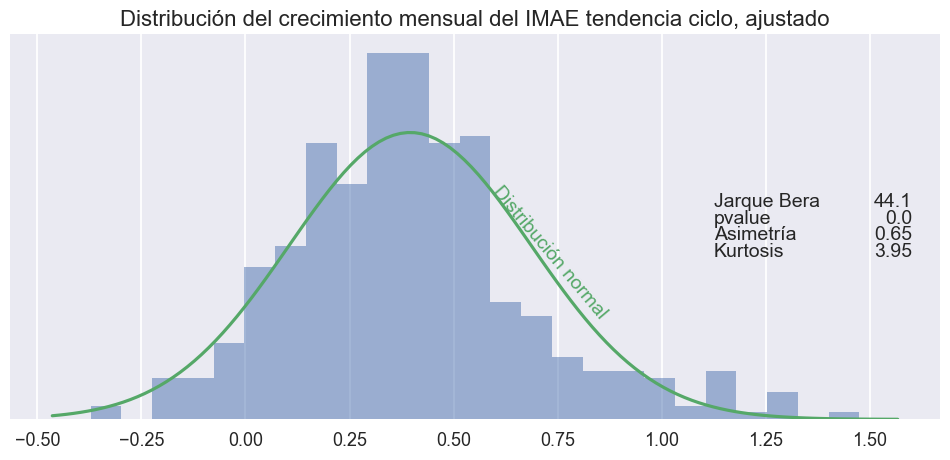

In [23]:
fig, ax = plt.subplots()

# dibujamos el histograma
growth.hist(ax=ax, bins=25, alpha=0.5, density=True)
xmin, xmax = ax.get_xlim()

# superponemos la distribución normal
x = np.linspace(xmin, xmax, 120)
p = norm.pdf(x, *norm.fit(growth))
ax.plot(x, p)
ax.annotate('Distribución normal', (x[70], p[75]), color='C1', rotation=-50, ha='center', fontsize=14)

# table es para escribir una pequeña tabla de valores a la derecha del gráfico
table = ax.table(cellText=jb.round(2).values.reshape(4,1), 
         rowLabels=jb.index, 
         edges='',
         loc='center right',
         colWidths=[0.1,0.1],
         zorder=1)

table.set_fontsize(14)

ax.set_title('Distribución del crecimiento mensual del IMAE tendencia ciclo, ajustado', fontsize=16)
ax.set_yticks([])

if SAVEFIGS:
    fig.savefig(figpath + "ej-imae-histograma.png")